In [1]:
#IMPORT LIBRARIES
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import re
import itertools
import json
import sys
import os
import time
import traceback
from lxml import etree
import json as json
from rdflib import Graph, URIRef, Namespace
#NEEDED BY PYKEEN
import scipy
import click
import more_itertools
import sklearn
import docdata
import pystow
import dataclasses_json
import click_default_group
import tabulate 
import torch
import optuna
import rexmex
import class_resolver
import requests
import tqdm
import more_click
import matplotlib
import seaborn
import time
from tqdm import tqdm


#RELATED TO PYKEEN
import tensorflow #as tf
import pykeen as pk
from pykeen.models import TransR, TransE
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.models.predict import get_tail_prediction_df
from pykeen.models import predict 
import pykeen.models as pkmodels
from pykeen.training import SLCWATrainingLoop
from pykeen.evaluation import RankBasedEvaluator

from torch.optim import Adam
from typing import List



/opt/anaconda3/envs/cse6250OlderPython/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/cse6250OlderPython/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/cse6250OlderPython/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/cse6250OlderPython/lib/python3.7/site-packages/tensorflow/python/

In [2]:
#HELPER FUNCTIONS


#UNIQUE PATIENT-MEDICAL CONCEPT TO BUILD GRAPH
def build_triplet_dataframe(df,head,relation,tail):
    triplet_df = df[[head, tail]].copy()
    triplet_df['RELATION'] = relation
    triplet_df = triplet_df.drop_duplicates()
    triplet_df = triplet_df.rename(columns={triplet_df.columns[0]: "Head",
                                            triplet_df.columns[1]: "Tail",
                                            triplet_df.columns[2]: "Relation"})
    triplet_df = triplet_df[["Head","Relation","Tail"]]
    #Convert to string so it can be accepted by pykeen's graph builder
    triplet_df["Head"] = triplet_df["Head"].astype(str)
    triplet_df["Tail"] = triplet_df["Tail"].astype(str)
    
      
    return triplet_df
    


## A. EXPERIMENTAL SETTINGS
### 1) DATASETS

#### Drugbank

In [11]:
#Adapted from: https://gist.github.com/rosherbal/56461421c69a8a7da775336c95fa62e0

class Drug:

    def __init__(self, features):

        self.id = features['id']
        self.name = features['name']
        self.synonyms = features['synm']
        self.kingdom = features['kgd']
        self.superclass = features['sclass']
        self.interaction = features['itrc']
        self.external_id = features['ext_id']
        self.pathways = features['pathways']
        self.target = []

    def getDrugfeatures(self):
        drug_dict = {"dg_id":self.id,
                    "dg_name":self.name,
                    "dg_synm":self.synonyms,
                    "dg_kingdom":self.kingdom,
                    "dg_superclass":self.superclass,
                    "dg_interactions":self.interaction,
                    "dg_ext_id":self.external_id,
                    "dg_pathways":self.pathways}
        return drug_dict

    def addTarget(self, feature_target):
        self.target.append(feature_target)

# Parameters and required variables #

dB_file = 'CSE6250_Project_Data/Drugbank.xml'
organism = 'Humans'

# Main script #

xtree = ET.parse(dB_file)
xroot = xtree.getroot()
drugs = list(xroot)

drug_targets = []
for i in tqdm(range(len(drugs))):
    drug = drugs[i]
    idDB = drug[0].text # Drug Bank ID

    for idx,feature in enumerate(drug):
        if 'name' in str(feature): # drug name
            drug_name = drug[idx].text

        if 'synonyms' in str(feature): # drug's synonyms
            drug_synm = ';'.join([synm.text \
                                    for synm in list(drug[idx])])

        if 'classification' in str(feature): #type of drug
            drug_class_kingdom = list(drug[idx])[2].text
            drug_class_superclass = list(drug[idx])[3].text

        if 'drug-interactions' in str(feature): #interaction other drugs
            drug_interaction = ';'.join([di[0].text
                                        for di in list(drug[idx])])

        if 'external-identifiers' in str(feature): #other drug's IDs
            aux = [ext_id[0].text + ":" + ext_id[1].text \
                                        for ext_id in list(drug[idx])]
            drug_external_id = ';'.join(aux)

        if 'pathways' in str(feature): #related pathways
            drug_pathway = ';'.join([pathway[1].text \
                                    for pathway in list(drug[idx])])

        if 'targets' in str(feature): #if polypeptide, drug's targets
            targets = list(drug[idx])

    # get all drug-related information in a dictionary
    drug_dict = {"id":idDB,
                "name":drug_name,
                "synm":drug_synm,
                "kgd":drug_class_kingdom,
                "sclass":drug_class_superclass,
                "itrc":drug_interaction,
                "ext_id":drug_external_id,
                "pathways":drug_pathway}
    drug = Drug(drug_dict)

    # get information of polypeptide targets
    if len(targets) > 0:
        for target in targets:
            idx_pep = None
            # get indexes
            for idx,feature in enumerate(target): # check features of targets
                if 'organism' in str(feature):
                    idx_org = idx
                if 'name' in str(feature):
                    idx_name = idx
                if 'actions' in str(feature):
                    idx_act = idx
                if 'polypeptide' in str(feature):
                    idx_pep = idx

            # Get information for polypeptide
            if target[idx_org].text == organism:

                target_name = target[idx_name].text

                actions = ';'.join([action.text
                                    for action in list(target[idx_act])])

                # Get information for polypeptide
                if idx_pep is not None: #if there is polypeptide's info...
                    for idx,feature in enumerate(target[idx_pep]):
                        if 'gene-name' in str(feature):
                            gene_name = target[idx_pep][idx].text
                        if 'cellular-location' in str(feature):
                            cell_loc = target[idx_pep][idx].text
                        if 'external-identifiers' in str(feature):
                            for ext_id in list(target[idx_pep][idx]):
                                if ext_id[0].text == "UniProtKB":
                                    uniprot = ext_id[1].text
                else:
                    gene_name = None
                    action = None
                    cell_loc = None
                    uniprot = None

                row = {
                        "dg_id":drug.id,
                        "dg_name":drug.name,
                        "dg_synm":drug.synonyms,
                        "dg_kingdom":drug.kingdom,
                        "dg_superclass":drug.superclass,
                        "dg_interactions":drug.interaction,
                        "dg_ext_id":drug.external_id,
                        "dg_pathways":drug.pathways,
                        "target_name":target_name,
                        "target_uniprot":uniprot,
                        "target_gene_name":gene_name,
                        "action":actions,
                        "cell_loc":cell_loc,
                        }

                drug_targets.append(row)


Drugbank_df = pd.DataFrame.from_dict(drug_targets, orient='columns')

100%|███████████████████████████████████| 14594/14594 [00:04<00:00, 2918.99it/s]


In [4]:
#Clean up Drugbank dataframex
Drugbank_df = Drugbank_df[['dg_id','dg_name','dg_synm','dg_interactions']]
Drugbank_df = Drugbank_df.drop_duplicates()
Drugbank_df.head(5)



,dg_id,dg_name,dg_synm,dg_interactions
0,DB00001,Lepirudin,Hirudin variant-1;Lepirudin;Lepirudin recombinant,DB06605;DB06695;DB01254;DB01609;DB01586;DB0212...
1,DB00002,Cetuximab,Cetuximab;Cétuximab;Cetuximabum,DB00255;DB00269;DB00286;DB00655;DB00783;DB0089...
9,DB00003,Dornase alfa,Deoxyribonuclease (human clone 18-1 protein mo...,
10,DB00004,Denileukin diftitox,Denileukin;Denileukin diftitox;Interleukin-2/d...,DB00012;DB00016;DB08894;DB09107
13,DB00005,Etanercept,Etanercept;etanercept-szzs;etanercept-ykro;Rec...,DB08879;DB00531;DB06643;DB00065;DB00008;DB0001...


In [12]:
print("Drugbank:",len(Drugbank_df['dg_id'].unique()))

Drugbank: 5927


#### ICD9-Ontology

In [5]:
#ICD9 ONTOLOGY
ICD9_Ontology = pd.read_csv('CSE6250_Project_Data/ICD9CM.csv.gz', compression='gzip',on_bad_lines='skip',low_memory=False)

#Extract ICD9 CODE FROM COLUMNS
ICD9_Ontology['ICD9_CODE'] = ICD9_Ontology['Class ID'].str.extract(r'((?<=ICD9CM[/]).*$)', expand=True)
ICD9_Ontology['Parents_ID'] = ICD9_Ontology['Parents'].str.extract(r'((?<=ICD9CM[/]).*$)', expand=True)
ICD9_Ontology = ICD9_Ontology[['ICD9_CODE','Preferred Label','Parents_ID','ICE','ICN', 'Scope Statement']]
ICD9_Ontology = ICD9_Ontology.dropna(subset=['ICD9_CODE'])
ICD9_Ontology['ICD9_CODE'] = ICD9_Ontology.apply(lambda x: x['ICD9_CODE'].replace('.',''), axis=1)


In [6]:

ICD9_Ontology.head()

,ICD9_CODE,Preferred Label,Parents_ID,ICE,ICN,Scope Statement
0,8372,Recession of tendon,83.7,NaN,NaN,NaN
1,9878,"Toxic effect of other specified gases, fumes, ...",987,Phosgene; Polyester fumes,NaN,NaN
2,8023,"Arthroscopy, wrist",80.2,NaN,NaN,NaN
3,3464,Menstrual migraine,346,Menstrual headache; Menstrually related migrai...,NaN,NaN
4,65513,"Chromosomal abnormality in fetus, affecting ma...",655.1,NaN,NaN,NaN


#### MIMIC III Data

In [3]:
#LOAD DATA

#MIMIC III DATA
#Defines each SUBJECT_ID in the database, i.e. defines a single patient.
#Patients = pd.read_csv('CSE6250_Project_Data/PATIENTS.csv.gz', compression='gzip',on_bad_lines='skip',low_memory=False)
#Define a patient’s hospital admission
Admissions = pd.read_csv('CSE6250_Project_Data/ADMISSIONS.csv.gz', compression='gzip',on_bad_lines='skip',low_memory=False)
#Contains ICD diagnoses for patients, most notably ICD-9 diagnoses.
Diagnoses = pd.read_csv('CSE6250_Project_Data/DIAGNOSES_ICD.csv.gz', compression='gzip',on_bad_lines='skip',low_memory=False)
#Contains medication related order entries, i.e. prescriptions.
Medication = pd.read_csv('CSE6250_Project_Data/PRESCRIPTIONS.csv.gz', compression='gzip',on_bad_lines='skip',low_memory=False)
#Contains ICD procedures for patients, most notably ICD-9 procedures
Procedures_ICD  = pd.read_csv('CSE6250_Project_Data/PROCEDURES_ICD.csv.gz', compression='gzip',on_bad_lines='skip',low_memory=False)
#Contains all notes for patients
#Note_Events = pd.read_csv('CSE6250_Project_Data/NOTEEVENTS.csv.gz', compression='gzip',on_bad_lines='skip',low_memory=False)

#Contains current procedural terminology (CPT) codes, which facilitate billing for procedures performed on patients.
#Procedures_CPT  = pd.read_csv('CSE6250_Project_Data/CPTEVENTS.csv.gz', compression='gzip',error_bad_lines=False,low_memory=False)
#Contains all laboratory measurements for a given patient, including out patient data.
#LAB_Events = pd.read_csv('CSE6250_Project_Data/LABEVENTS.csv.gz', compression='gzip',error_bad_lines=False,low_memory=False)

#DICTIONARIES
#High-level definitions for current procedural terminology (CPT) codes.
#D_CPT = pd.read_csv('CSE6250_Project_Data/D_CPT.csv.gz', compression='gzip',error_bad_lines=False,low_memory=False)
#Definition table for ICD diagnoses.
#D_ICD_Diagnoses = pd.read_csv('CSE6250_Project_Data/D_ICD_DIAGNOSES.csv.gz', compression='gzip',error_bad_lines=False,low_memory=False)
#Definition table for ICD procedures.
#D_ICD_Procedures = pd.read_csv('CSE6250_Project_Data/D_ICD_PROCEDURES.csv.gz', compression='gzip',error_bad_lines=False,low_memory=False)
#Definition table for all laboratory measurements.
#D_ICD_LabItems = pd.read_csv('CSE6250_Project_Data/D_LABITEMS.csv.gz', compression='gzip',error_bad_lines=False,low_memory=False)

#FORMAT AND CLEAN DATASETS
Diagnoses = Diagnoses[['SUBJECT_ID','HADM_ID','ICD9_CODE']]
Diagnoses = Diagnoses.drop_duplicates()
Diagnoses = Diagnoses[Diagnoses['ICD9_CODE'].notna()]


Medication = Medication[['SUBJECT_ID','HADM_ID','NDC','DRUG','DRUG_NAME_GENERIC']]
Medication = Medication.drop_duplicates()
Medication['NDC'] = Medication['NDC'].astype(str)
Medication = Medication[(Medication['NDC'].notna()) &(Medication['NDC']!= '0.0')]

Procedures_ICD = Procedures_ICD[['SUBJECT_ID','HADM_ID','ICD9_CODE']]
Procedures_ICD = Procedures_ICD.drop_duplicates()
Procedures_ICD = Procedures_ICD[Procedures_ICD['ICD9_CODE'].notna()]

In [4]:
#DISEASE DEFINITION
#Tuples for every disease in case we need to add/remove
atherosclerosis = ('440','4140','4143','4144','4370')
    
heart_failure = ('39891','40201','40211','40291','40401','40403','40411','40413','40491','40493','428')
    
kidney_failure = ('584','6393','6693')
    
intestinal_diseases = ('001','002','003','004','005','006','007','008','009',  '0222', '1590', '1230', '1234', 
                            '1277', '1278', '1279', '129','1763', '2713', '27703', '3064', '56081', '56089', '5609', 
                            '5643','56979', '5789', '5798', '5799', '538', '7514', '74761', '7131','7724', '7772','7776',
                            '9473', '9733', '9738', '9739', 'V1000','V1009', 'V453', 'V5350', 'V5359', 'V757','7934',
                            'E9433','E9438', 'E9439', '86380', 'V023', 'V444', 'V160', 'E8584','86389', '86390','86399')
    
liver_diseases = ('0063', '0953','1225', '1228', '1550', '1552','1977','2308', '2353', '20972', '2115', '570', 
                      '571','64670','64671','64673','7516','864','9641','99682','V427','V1007')
    
pneumonia = ('00322','0116','0382','0551','0730''11505', '11515', '11595','480','481','482','483','484','485',
                 '486','4870','48801', '48811', '48881','5163','5171', '7700','99731','99732','V1261')
    
septicemia = ('0031','0223','038','0545', '77181')
    
respiratory_failure = ('5185','5188','77084')
    
gastritis = ('535',)
    
diseases_ICD9_codes = atherosclerosis + heart_failure + kidney_failure + intestinal_diseases + liver_diseases + pneumonia + septicemia + respiratory_failure + gastritis


### 2) MEDICAL KNOWLEDGE GRAPH CONSTRUCTION

#### a: THE SELECTION OF PATIENTS

In [9]:
#TO LIMIT PATIENT AMOUNT FOR TESTS
Admissions = Admissions[Admissions.SUBJECT_ID<=500]

In [5]:
#a: THE SELECTION OF PATIENTS

#Patient Cohort : Atherosclerosis, Heart Failure, Kidney Failure, Intestinal Diseases, Liver Diseases, 
#Pneumonia, Septicemia, Respiratory Failure, and Gastritis

Patient_Cohort = pd.merge(Admissions[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME']],
                         Diagnoses[['SUBJECT_ID','HADM_ID','ICD9_CODE']],
                         how = "left",
                         left_on = ['SUBJECT_ID','HADM_ID'],
                         right_on = ['SUBJECT_ID','HADM_ID'])
Patient_Cohort['ADMITTIME'] = pd.to_datetime(Patient_Cohort['ADMITTIME']).dt.date
Patient_Cohort['DISCHTIME'] = pd.to_datetime(Patient_Cohort['DISCHTIME']).dt.date
Patient_Cohort = Patient_Cohort[Patient_Cohort['ICD9_CODE'].notna()]


#Get the SUBJECT_ID and HADM_ID for patients suffering one of the cohort deseases and filter the Patient_Cohort dataset
Diagnosis_Cohort = Diagnoses[(Diagnoses["ICD9_CODE"].notna()) & (Diagnoses['ICD9_CODE'].str.startswith(diseases_ICD9_codes))]
ICD9_Complete_List = set(Diagnosis_Cohort['ICD9_CODE'].unique())
Patient_Cohort = pd.merge(Patient_Cohort,
                         Diagnosis_Cohort[['SUBJECT_ID']],
                         how = 'inner',
                         left_on =['SUBJECT_ID'],
                         right_on = ['SUBJECT_ID'])



#(1) We remove the patients with missing data on admission date and discharge date
Patient_Cohort = Patient_Cohort.dropna(subset=['ADMITTIME','DISCHTIME'])

#(2) We keep the patients which consist of at least three ICD-9 codes
#Create dataset copy with ICD9_Code grouped by visit
Grouped_ICD9_By_Visit = pd.DataFrame(Patient_Cohort.groupby(['SUBJECT_ID'])['ICD9_CODE'].apply(set)).reset_index()
Grouped_ICD9_By_Visit['ICD9_Count'] = Grouped_ICD9_By_Visit.apply(lambda x: len(x['ICD9_CODE']), axis=1)
Grouped_ICD9_By_Visit = Grouped_ICD9_By_Visit[Grouped_ICD9_By_Visit['ICD9_Count']>=3]

Patient_Cohort = pd.merge(Patient_Cohort,
                         Grouped_ICD9_By_Visit[['SUBJECT_ID']],
                         how = 'inner',
                         left_on = ['SUBJECT_ID'],
                         right_on = ['SUBJECT_ID'])

#(3) We remove the patients which have the discharge date after 2200/1/1
Patient_Cohort = Patient_Cohort[(Patient_Cohort['DISCHTIME'].astype(str) <= '2200-1-1')]


#COMENTED BECAUSE THE PATIENT COUNT GOT TOO LOW
#(4) we remove the patients who suffer from more than one disease in the cohort list.
# Multiple_Cohort_Desease = pd.DataFrame(Patient_Cohort.groupby(['SUBJECT_ID'])['ICD9_CODE'].apply(set)).reset_index()
# Multiple_Cohort_Desease['Disease_Set'] = Multiple_Cohort_Desease.apply(lambda x: len(x['ICD9_CODE'].intersection(ICD9_Complete_List)), axis=1)
# Unique_Cohort_Disease = Multiple_Cohort_Desease[Multiple_Cohort_Desease['Disease_Set'] ==1]

# Patient_Cohort = pd.merge(Patient_Cohort,
#                            Unique_Cohort_Disease[['SUBJECT_ID']],
#                            how = 'inner',
#                            left_on = ['SUBJECT_ID'],
#                            right_on = ['SUBJECT_ID'])


#### b: THE SELECTION OF MEDICAL CONCEPTS

In [6]:
#b: THE SELECTION OF MEDICAL CONCEPTS
Patient_Cohort.head()

#Reduce Patient_Cohort dataset
Patient_Cohort = Patient_Cohort[['SUBJECT_ID','ICD9_CODE']]
Patient_Cohort = Patient_Cohort.drop_duplicates()

#MEDICATION
#Reduce Medication_cohort dataset
Medication_Cohort = Medication[['SUBJECT_ID','DRUG','NDC']]
Medication_Cohort = Medication_Cohort.drop_duplicates()

Medication_Cohort = pd.merge(Medication_Cohort,
                             Patient_Cohort[['SUBJECT_ID']],
                              how = 'inner',
                              left_on = ['SUBJECT_ID'],
                              right_on = ['SUBJECT_ID'] )

Medication_Cohort = Medication_Cohort.drop_duplicates()

#PROCEDURES
Procedures_Cohort = Procedures_ICD[['SUBJECT_ID','ICD9_CODE']]
Procedures_Cohort = Procedures_Cohort.drop_duplicates()

Procedures_Cohort = pd.merge(Procedures_Cohort,
                            Patient_Cohort[['SUBJECT_ID']],
                             how = 'inner',
                             left_on = ['SUBJECT_ID'],
                             right_on = ['SUBJECT_ID'] )

Procedures_Cohort = Procedures_Cohort.drop_duplicates()

#Remove medical concepts which appear less than five patients to avoid biases and noise
#DIAGNOSES
ICD9_CODE_Patient_Count = Patient_Cohort.groupby(["ICD9_CODE"], as_index= False)["SUBJECT_ID"].count()
ICD9_CODE_Patient_Count = ICD9_CODE_Patient_Count[ICD9_CODE_Patient_Count['SUBJECT_ID']>=5]

Patient_Cohort = pd.merge(Patient_Cohort,
                          ICD9_CODE_Patient_Count[['ICD9_CODE']],
                           how = 'inner',
                           left_on = 'ICD9_CODE',
                           right_on = 'ICD9_CODE')


#MEDICATION
Medication_Patient_Count = Medication_Cohort.groupby(["NDC"], as_index= False)["SUBJECT_ID"].count()
Medication_Patient_Count = Medication_Patient_Count[Medication_Patient_Count['SUBJECT_ID']>=5]

Medication_Cohort = pd.merge(Medication_Cohort,
                        Medication_Patient_Count[['NDC']],
                         how = 'inner',
                         left_on = 'NDC',
                         right_on = 'NDC')

#PROCEDURES
Procedures_Patient_Count = Procedures_Cohort.groupby(["ICD9_CODE"], as_index= False)["SUBJECT_ID"].count()
Procedures_Patient_Count = Procedures_Patient_Count[Procedures_Patient_Count['SUBJECT_ID']>=5]

Procedures_Cohort = pd.merge(Procedures_Cohort,
                        Procedures_Patient_Count[['ICD9_CODE']],
                         how = 'inner',
                         left_on = 'ICD9_CODE',
                         right_on = 'ICD9_CODE')


In [7]:
print("Final Patient Cohort Dataset also used for Diagnosis Cohort:")
print("Patient_Cohort:",len(Patient_Cohort['SUBJECT_ID'].unique()))
#Diagnosis Count
print("Diagnosis Cohort:",len(Patient_Cohort['ICD9_CODE'].unique()))

#Medication Count
print("Medication_Cohort:",len(Medication_Cohort['DRUG'].unique()))

#Procedure Count
print("Procedure_Cohort:",len(Procedures_Cohort['ICD9_CODE'].unique()))

Final Patient Cohort Dataset also used for Diagnosis Cohort:
Patient_Cohort: 28592
Diagnosis Cohort: 3180
Medication_Cohort: 3585
Procedure_Cohort: 953


In [8]:
#B. MEDICAL KNOWLEDGE TRIPLETS
#CREATE DATAFRAME OF TRIPLETS IN THE FORM [(4, 'diagnosed', '2763'),(4, 'performed', 3893),(4, 'prescribed', 'Heparin')...]

Patient_Diagnoses_Triplets = build_triplet_dataframe(Patient_Cohort,'SUBJECT_ID','diagnosed','ICD9_CODE')
Patient_Medications_Triplets = build_triplet_dataframe(Medication_Cohort,'SUBJECT_ID','prescribed','DRUG')
Patient_Procedures_Triplets = build_triplet_dataframe(Procedures_Cohort,'SUBJECT_ID','performed','ICD9_CODE')

Medical_Knowledge_Triplets_df = pd.concat([Patient_Diagnoses_Triplets,
                                            Patient_Medications_Triplets,
                                            Patient_Procedures_Triplets],ignore_index=True)
Medical_Knowledge_Triplets_df = Medical_Knowledge_Triplets_df.sort_values(by=['Head'])

Medical_Knowledge_Triplets_df.head(5)

Medical_Knowledge_Triplets_List = [tuple(r) for r in Medical_Knowledge_Triplets_df.to_numpy().tolist()]

In [9]:

Medical_Knowledge_Triplets_df.head(5)

,Head,Relation,Tail
476459,1000,prescribed,Vancomycin HCl
342817,1000,diagnosed,5789
1470362,1000,prescribed,D5W (GLASS BOTTLE)
540740,1000,prescribed,Pantoprazole
344206,1000,diagnosed,0380


In [10]:
#Count Relationships
print("Patient - Diagnoses:",len(Medical_Knowledge_Triplets_df[Medical_Knowledge_Triplets_df['Relation'] == 'diagnosed']))

print("Patient - Medication:",len(Medical_Knowledge_Triplets_df[Medical_Knowledge_Triplets_df['Relation'] == 'prescribed']))

print("Patient - Procedures:",len(Medical_Knowledge_Triplets_df[Medical_Knowledge_Triplets_df['Relation'] == 'performed']))




Patient - Diagnoses: 450915
Patient - Medication: 1108080
Patient - Procedures: 167829


In [16]:
#CREATE MEDICAL ENTITY TRIPLETS
#Purpose: Stack the Medical Entity Triplets dataframe on top of the medical entity triplets to train the embedding model

#DRUGS: Using MIMIC III Drug name['DRUG'] link as 'SameAs' to Dugbank id 'drugbank_id'
#Example: (Insuline, SameAs, DB00030)

### Testing and Training Medical Knowledge Graph Embedding Models

In [17]:
#Convert data to labeled triplets and split into training, testing and validation sets
#To feed the models

tf = TriplesFactory.from_labeled_triples(Medical_Knowledge_Triplets_df[['Head','Relation','Tail']].values)
training, testing, validation = tf.split([.8, .1, .1])

#GET labels and IDS
labels = [x for x in list(tf.entity_id_to_label.values()) if '^^' not in x]
ids = torch.as_tensor(tf.entities_to_ids(labels))

using automatically assigned random_state=507084747


### MODEL 1

In [18]:
#  MEDICAL KNOWLEDGE GRAPH EMBEDDINGS USING PYKEEN'S TRANSR METHOD 1 USING PIPELINE

#Train a knowledge graph embedding model

result = pipeline(
     training=training,
     testing=testing,
     validation=validation,
     model='TransR',
     stopper='early',
     epochs=2,
     dimensions=512,
     random_seed=420)

No cuda devices were available. The model runs on CPU
/opt/anaconda3/envs/cse6250OlderPython/lib/python3.7/site-packages/pykeen/nn/representation.py:375: UserWarning: Directly use Embedding.shape instead of num_embeddings.
  warnings.warn(f"Directly use {self.__class__.__name__}.shape instead of num_embeddings.")
/opt/anaconda3/envs/cse6250OlderPython/lib/python3.7/site-packages/pykeen/nn/representation.py:369: UserWarning: Directly use Embedding.max_id instead of num_embeddings.
  warnings.warn(f"Directly use {self.__class__.__name__}.max_id instead of num_embeddings.")
Training batches on cpu:  92%|████████████▉ | 37/40 [00:00<00:00, 113.57batch/s]
Training epochs on cpu:  50%|▌| 1/2 [00:04<00:04,  4.97s/epoch, loss=0.00374, pr
Training batches on cpu:  92%|████████████▉ | 37/40 [00:00<00:00, 120.69batch/s]
Training epochs on cpu: 100%|█| 2/2 [00:09<00:00,  4.87s/epoch, loss=0.00306, pr
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but y

In [19]:
#Saving and Restoring Model
#PyKeen Models are torch models with utility functions on the top. 
#We can use the torch’s functionality to save and reload a model.
torch.save(result.model,'result_trained_model.pkl')
result_pykeen_model = torch.load('result_trained_model.pkl') 
print(result_pykeen_model)

TransR(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (regularizer): NoRegularizer()
  (entity_embeddings): Embedding(
    (_embeddings): Embedding(928, 50)
  )
  (relation_embeddings): Embedding(
    (_embeddings): Embedding(3, 30)
  )
  (relation_projections): Embedding(
    (_embeddings): Embedding(3, 1500)
  )
)


In [44]:
#Print some info using the first model

tail_prediction_df = get_tail_prediction_df(result.model, 'Metronidazole', 'prescribed', triples_factory=result.training)
print(tail_prediction_df.head(5))

entity_representation_modules: List['pykeen.nn.Representation'] = result.model.entity_representations
relation_representation_modules: List['pykeen.nn.Representation'] = result.model.relation_representations
    
print(entity_representation_modules)
print(relation_representation_modules)

entity_embeddings: pk.nn.Embedding = entity_representation_modules[0]
relation_embeddings: pk.nn.Embedding = relation_representation_modules[0]
    
print(entity_embeddings)
print(relation_embeddings)

entity_embedding_tensor: torch.FloatTensor = entity_embeddings()
relation_embedding_tensor: torch.FloatTensor = relation_embeddings()
    
print(entity_embedding_tensor.size())
print(relation_embedding_tensor.size())

     tail_id      tail_label     score  in_training
731      731       Lorazepam -0.773875        False
665      665     Haloperidol -0.798839        False
749      749      Metoprolol -0.806764        False
550      550       Bisacodyl -0.816760        False
775      775  NEO*PO*Mct Oil -0.906666        False
[Embedding(
  (_embeddings): Embedding(928, 50)
)]
[Embedding(
  (_embeddings): Embedding(3, 30)
)]
Embedding(
  (_embeddings): Embedding(928, 50)
)
Embedding(
  (_embeddings): Embedding(3, 30)
)
torch.Size([928, 50])
torch.Size([3, 30])


/opt/anaconda3/envs/cse6250OlderPython/lib/python3.7/site-packages/pykeen/nn/representation.py:375: UserWarning: Directly use Embedding.shape instead of num_embeddings.
  warnings.warn(f"Directly use {self.__class__.__name__}.shape instead of num_embeddings.")


In [21]:
embeddings = result.model.entity_representations
embedding_representation_df = pd.DataFrame(embeddings[0](indices=ids)
                   .detach()
                   .numpy(),index=labels,columns=list(range(0, result.model.embedding_dim)))

/opt/anaconda3/envs/cse6250OlderPython/lib/python3.7/site-packages/pykeen/nn/representation.py:375: UserWarning: Directly use Embedding.shape instead of num_embeddings.
  warnings.warn(f"Directly use {self.__class__.__name__}.shape instead of num_embeddings.")


In [22]:
embedding_representation_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
*NF* Nicardipine HCl IV,0.205108,-0.101243,-0.152330,0.112078,-0.090383,0.210989,0.171774,0.224311,-0.190046,-0.203977,...,0.083742,0.214433,0.112277,-0.198117,-0.104945,-0.183558,0.229560,0.037321,-0.097408,-0.031902
0.45% Sodium Chloride,-0.081522,0.066412,0.007588,-0.191634,-0.107027,-0.232876,-0.136447,0.035993,0.147740,-0.231134,...,0.033108,0.210046,-0.011567,0.103231,-0.250425,0.114227,-0.077368,0.219577,0.022018,-0.122123
0.9% Sodium Chloride,0.137703,-0.248062,-0.188113,0.066428,-0.020763,0.199643,-0.118273,-0.198928,-0.149504,-0.117774,...,-0.057951,0.081863,0.211062,-0.139263,0.225368,-0.241375,0.029532,0.075029,-0.021189,0.068545
0.9% Sodium Chloride (Mini Bag Plus),-0.088724,-0.066627,0.154116,-0.047922,0.140770,-0.172394,-0.221316,0.193179,-0.165521,0.085249,...,-0.251987,-0.212202,0.000738,-0.133101,-0.037230,-0.040249,0.099155,0.149628,0.106624,0.196304
00845,0.070883,0.127026,-0.027092,-0.005722,0.158307,0.200643,0.033382,0.182399,-0.120234,0.056256,...,0.188659,0.172000,0.127608,-0.224162,-0.101321,0.096793,-0.112995,-0.195560,-0.018581,-0.229048


### TRAIN NEURAL NETWORK MODEL

In [158]:
#NN MODEL 1

from tensorflow.keras import datasets, layers, models

nn_model = models.Sequential()

# Apply linear activation function to input layer
# Generate hidden layer with 14 nodes, the same as the input layer
nn_model.add(layers.Dense(units=50, activation='linear',input_dim=50))
nn_model.add(layers.Dense(units=50, activation='linear'))
# Apply linear activation function to hidden layer
# Generate output layer with 14 nodes
nn_model.add(layers.Dense(units=50, activation='linear'))
# Compile the model
nn_model.compile(optimizer='adam',
              loss='mean_squared_error',
              #loss='binary_crossentropy',
              #loss='categorical_crossentropy',
              metrics=['accuracy'])

print(nn_model.summary())

# Train the model
num_epochs = 100
batch_size = 256
nn_model_history = nn_model.fit(x=entity_embedding_tensor.detach().numpy(), y=entity_embedding_tensor.detach().numpy(),
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(entity_embedding_tensor.detach().numpy(), entity_embedding_tensor.detach().numpy()),
                    verbose=False)


print(nn_model_history.history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_112 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_113 (Dense)            (None, 50)                2550      
Total params: 7,650
Trainable params: 7,650
Non-trainable params: 0
_________________________________________________________________
None
{'loss': [0.03713668754388546, 0.03265989828726341, 0.029083834704140138, 0.026074512123033917, 0.02362283235736962, 0.02157231709309693, 0.01983779707345469, 0.01837619214222349, 0.0171242393553257, 0.01603235233703564, 0.015076183617628854, 0.014227796153261744, 0.013475136799288207, 0.01279804348174868, 0.012182221747934818, 0.011622042363059932, 0.011106876720642221, 0.010633442454553884, 0.0

In [146]:
nn_test_loss, nn_test_acc = nn_model.evaluate(entity_embedding_tensor.detach().numpy(),  entity_embedding_tensor.detach().numpy(), verbose=2)

 - 0s - loss: 0.0013 - acc: 0.4343


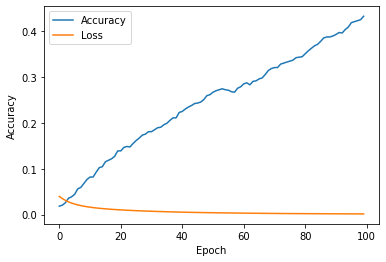

In [145]:
plt.plot(nn_model_history.history['acc'], label='Accuracy')
plt.plot(nn_model_history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='upper left')

In [94]:
# plt.plot(history.history['acc'], label='accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

# test_loss, test_acc = conv_model.evaluate(entity_embedding_tensor.detach().numpy(),entity_embedding_tensor.detach().numpy() , verbose=2)



### MODEL 2

In [72]:
#  MEDICAL KNOWLEDGE GRAPH EMBEDDINGS USING PYKEEN'S TRANSR METHOD 2 USING PIPELINE
#THIS MODELS USES 2 EMBEDDING DIMENSIONS AS OUTPUT

results2 = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model = 'TransR',
    model_kwargs=dict(embedding_dim=2),
    optimizer_kwargs=dict(lr=1.0e-1),
    training_kwargs=dict(num_epochs=2, use_tqdm_batch=False),
    random_seed=1,
    device='cpu',
)


INFO:pykeen.pipeline.api:Using device: cpu
/opt/anaconda3/envs/cse6250OlderPython/lib/python3.7/site-packages/pykeen/nn/representation.py:375: UserWarning: Directly use Embedding.shape instead of num_embeddings.
  warnings.warn(f"Directly use {self.__class__.__name__}.shape instead of num_embeddings.")
/opt/anaconda3/envs/cse6250OlderPython/lib/python3.7/site-packages/pykeen/nn/representation.py:369: UserWarning: Directly use Embedding.max_id instead of num_embeddings.
  warnings.warn(f"Directly use {self.__class__.__name__}.max_id instead of num_embeddings.")
Training epochs on cpu: 100%|█| 2/2 [00:00<00:00,  3.80epoch/s, loss=0.00208, pr
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
Evaluating on cpu: 100%|██████████████| 1.27k/1.27k [00:00<00:00, 1.38ktriple/s

In [73]:
#Saving and Restoring Model
#PyKeen Models are torch models with utility functions on the top. 
#We can use the torch’s functionality to save and reload a model.
torch.save(results2.model,'results2_trained_model.pkl')
results2_pykeen_model = torch.load('results2_trained_model.pkl') 
print(results2_pykeen_model)

TransR(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (regularizer): NoRegularizer()
  (entity_embeddings): Embedding(
    (_embeddings): Embedding(928, 2)
  )
  (relation_embeddings): Embedding(
    (_embeddings): Embedding(3, 30)
  )
  (relation_projections): Embedding(
    (_embeddings): Embedding(3, 60)
  )
)


In [74]:
#Print some info using the second model
tail_prediction_df2 = get_tail_prediction_df(results2.model, 'Metronidazole', 'prescribed', triples_factory=results2.training)
print(tail_prediction_df2.head(5))

entity_representation_modules2: List['pykeen.nn.Representation'] = results2.model.entity_representations
relation_representation_modules2: List['pykeen.nn.Representation'] = results2.model.relation_representations
    
print(entity_representation_modules2)
print(relation_representation_modules2)

entity_embeddings2: pk.nn.Embedding = entity_representation_modules2[0]
relation_embeddings2: pk.nn.Embedding = relation_representation_modules2[0]
    
print(entity_embeddings2)
print(relation_embeddings2)

entity_embedding_tensor2: torch.FloatTensor = entity_embeddings2()
relation_embedding_tensor2: torch.FloatTensor = relation_embeddings2()
    
print(entity_embedding_tensor2)
print(relation_embedding_tensor2)

print(entity_embedding_tensor2.shape)
print(relation_embedding_tensor2.shape)

     tail_id        tail_label     score  in_training
627      627      Epoetin Alfa -0.499411        False
630      630      Erythromycin -0.500140        False
844      844  Promethazine HCl -0.505781        False
599      599     Dexamethasone -0.506753        False
635      635   Famotidine (IV) -0.507375        False
[Embedding(
  (_embeddings): Embedding(928, 2)
)]
[Embedding(
  (_embeddings): Embedding(3, 30)
)]
Embedding(
  (_embeddings): Embedding(928, 2)
)
Embedding(
  (_embeddings): Embedding(3, 30)
)
tensor([[ 0.5875,  0.8093],
        [-0.8937,  0.2061],
        [ 0.8751,  0.0209],
        ...,
        [-0.5625,  0.3090],
        [ 0.5673,  0.1297],
        [-0.0554, -0.9985]], grad_fn=<ViewBackward0>)
tensor([[ 0.2716, -0.0909,  0.2029,  0.0140, -0.0839, -0.1546, -0.0946,  0.1104,
          0.1841, -0.2262, -0.2233, -0.0906, -0.1970,  0.0608, -0.2062, -0.1136,
         -0.2351,  0.2381,  0.1590,  0.2739,  0.1528, -0.1790,  0.2487, -0.2943,
          0.2205,  0.0065, -0.19

In [75]:
entity_representation = results2.model.entity_representations[0]
print(entity_representation)


Embedding(
  (_embeddings): Embedding(928, 2)
)


In [76]:
embeddings2 = results2.model.entity_representations
embedding_representation_df2 = pd.DataFrame(embeddings2[0](indices=ids)
                   .detach()
                   .numpy(),index=labels,columns=list(range(0, results2.model.embedding_dim)))

embedding_representation_df2.head()

/opt/anaconda3/envs/cse6250OlderPython/lib/python3.7/site-packages/pykeen/nn/representation.py:375: UserWarning: Directly use Embedding.shape instead of num_embeddings.
  warnings.warn(f"Directly use {self.__class__.__name__}.shape instead of num_embeddings.")


,0,1
*NF* Nicardipine HCl IV,0.587454,0.809257
0.45% Sodium Chloride,-0.893690,0.206063
0.9% Sodium Chloride,0.875134,0.020876
0.9% Sodium Chloride (Mini Bag Plus),0.798634,-0.601817
00845,-0.091921,0.995766


### 3) MEDICAL ENTITY DESCRIPTION RETRIEVAL

In [ ]:
#For patient entity descriptions,we use the discharge summary associated with each patient from MIMIC-III
MIMIC_Discharge_Summary = Note_Events[Note_Events['CATEGORY'] == 'Discharge summary']
MIMIC_Discharge_Summary = MIMIC_Discharge_Summary[['SUBJECT_ID','TEXT']]
MIMIC_Discharge_Summary = MIMIC_Discharge_Summary.dropna(subset = ['TEXT'])
MIMIC_Discharge_Summary = MIMIC_Discharge_Summary.drop_duplicates()

In [ ]:
pd.set_option('display.max_colwidth', None)
display(MIMIC_Discharge_Summary.head(5))

### C. PATIENT SIMILARITY LEARNING

In [78]:
#embedding_values = _model_to_numpy(best_model)

#embedding_values = result.model.entity_embeddings.weight.detach().cpu().numpy()
result.model.relation_dim

30

In [97]:
from ampligraph.datasets import load_fb15k_237
from ampligraph.evaluation import train_test_split_no_unseen, evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.discovery import query_topn, discover_facts, find_clusters
from ampligraph.latent_features import TransE, ComplEx, HolE, DistMult, ConvE, ConvKB
from ampligraph.utils import save_model, restore_model

In [81]:
import tensorflow as tf

print(tf.__version__)

1.13.2


In [88]:

display(Medical_Knowledge_Triplets_df.head(5))
Medical_Knowledge_Triplets_df_tmp = Medical_Knowledge_Triplets_df[Medical_Knowledge_Triplets_df.Head != "None"]
test_train, X_valid = train_test_split_no_unseen(Medical_Knowledge_Triplets_df[['Head','Relation','Tail']].values, 500, seed=0) 

X_train, X_test = train_test_split_no_unseen(test_train, 1000, seed=0)

,Head,Relation,Tail
11365,101,performed,9672
1341,101,diagnosed,5121
11483,101,performed,3893
12543,101,performed,3404
2123,101,diagnosed,4275


In [90]:
model = TransE(k=150,                                                             # embedding size
               epochs=100,                                                        # Num of epochs
               batches_count= 10,                                                 # Number of batches 
               eta=1,                                                             # number of corruptions to generate during training
               loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters         
               initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
               regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},   # regularizer along with its hyperparameters
               optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
               seed= 0, verbose=True)

model.fit(X_train)

from ampligraph.utils import save_model, restore_model
save_model(model, 'TransE.pkl')
model = restore_model('TransE.pkl')


Average TransE Loss:   0.044625: 100%|█████| 100/100 [00:04<00:00, 20.40epoch/s]


In [84]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

# restore the previously saved model to save time
model = restore_model('TransE.pkl')

# Get the entities that we want to cluster. Here we use all unique entities
all_entities = np.array(list(set(Medical_Knowledge_Triplets_df.values[:, 0]).union(Medical_Knowledge_Triplets_df.values[:, 2])))
print('Size of the subset being used for subset generation:', len(all_entities))

# create the clustering algorithm from sklearn
kmeans = KMeans(n_clusters=3, n_init=100, max_iter=500)

# call find_clusters to get the cluster assignments of the entities
clusters = find_clusters(all_entities, model, kmeans, mode='entity')

Size of the subset being used for subset generation: 928


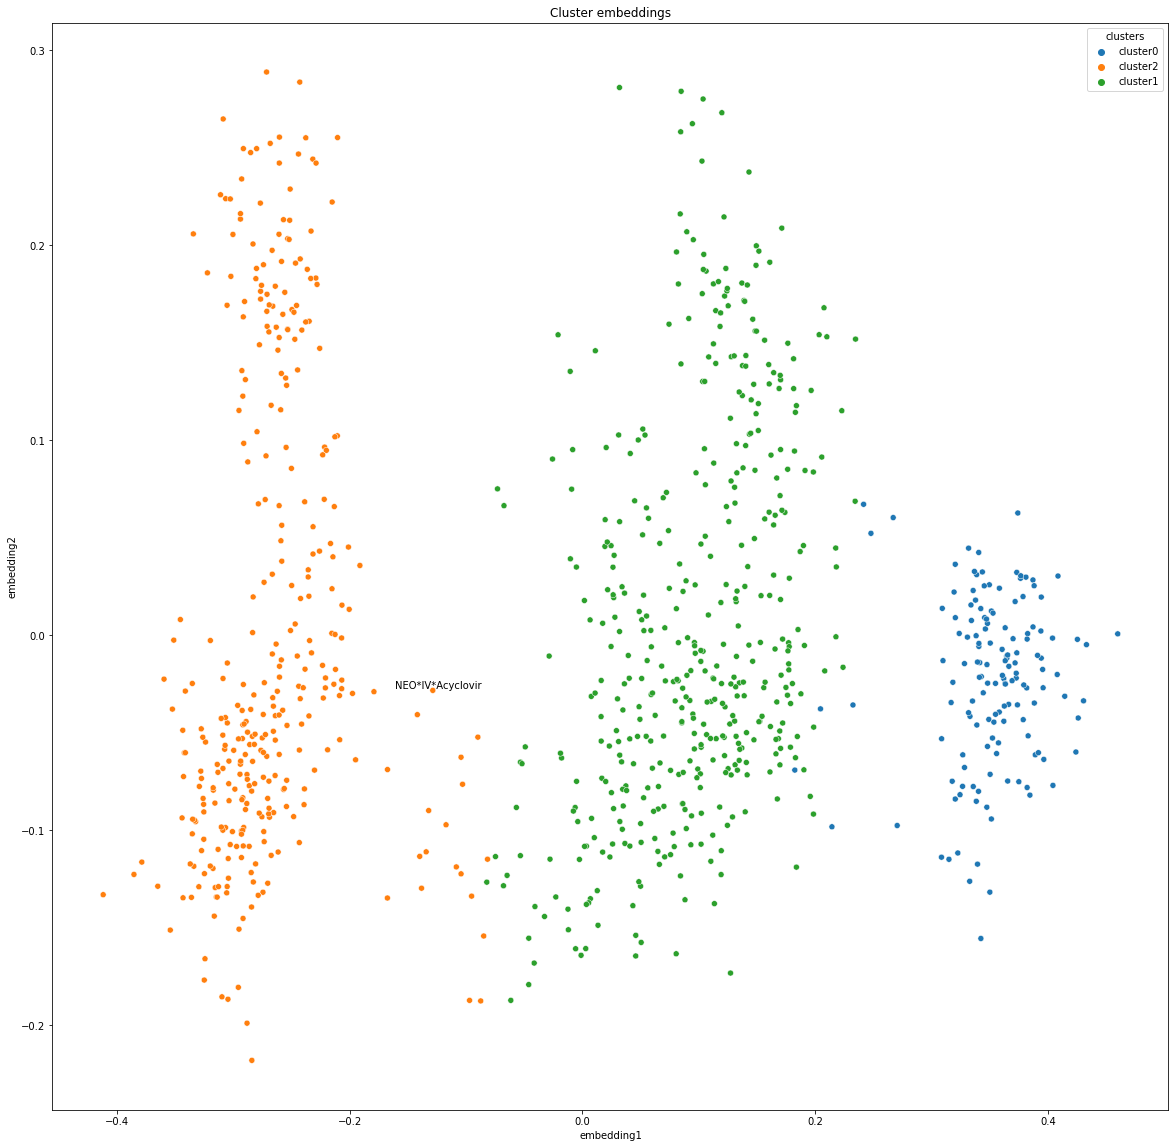

In [86]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Get the embeddings (150 dims) for all the entities of interest
jobs_embeddings = model.get_embeddings(all_entities, embedding_type='entity')

# Perform PCA and reduce the dims to 2
embeddings_2d = PCA(n_components=2).fit_transform(np.array([emb for emb in jobs_embeddings]))

# Create a dataframe to plot the embeddings using scatterplot
df = pd.DataFrame({"entities": all_entities, "clusters": "cluster" + pd.Series(clusters).astype(str),
                    "embedding1": embeddings_2d[:, 0], "embedding2": embeddings_2d[:, 1]})

plt.figure(figsize=(20, 20))
plt.title("Cluster embeddings")

ax = sns.scatterplot(data=df, x="embedding1", y="embedding2", hue="clusters")

# Print only a few labels, to avoid clutter, using adjust_text
from adjustText import adjust_text
texts = []
for i, point in df.iterrows():
    # randomly choose a few labels to be printed
    if np.random.uniform() < 0.003:
        texts.append(plt.text(point['embedding1']+.1, point['embedding2'], str(point['entities'])))
        
adjust_text(texts)
plt.show()